In [1]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pickle

import sqlite3
import os


In [2]:
# Load sql magic 
%load_ext sql


In [3]:
data_cab = pd.read_parquet('/Users/id/Downloads/yellow_tripdata_2024-06.parquet')
data_cab.to_csv('/Users/id/Downloads/yellow_tripdata_2024-06.csv', index=False)


In [4]:

data_cab = pd.read_csv('/Users/id/Downloads/yellow_tripdata_2024-06.csv',low_memory=False)

data_zone = pd.read_csv('/Users/id/Downloads/taxi_zone_lookup.csv')

In [5]:
data_zone.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [6]:
# Zone Look up column names updated
zone_column_update = {'LocationID' : 'location_id',
                     'Borough': 'borough',
                     'Zone' : 'zone',
                     }
data_zone = data_zone.rename(columns = zone_column_update)

In [7]:
data_zone.head()

,location_id,borough,zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [8]:
data_cab.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1.0,N,138,195,1,48.5,7.75,0.5,11.55,0.0,1.0,69.30,0.0,1.75
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1.0,N,138,7,1,20.5,6.00,0.5,8.40,0.0,1.0,38.15,0.0,1.75
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1.0,N,166,41,1,10.0,1.00,0.5,3.10,0.0,1.0,15.60,0.0,0.00
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1.0,N,148,114,1,8.6,3.50,0.5,0.20,0.0,1.0,13.80,2.5,0.00
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1.0,N,148,249,1,7.2,3.50,0.5,2.00,0.0,1.0,14.20,2.5,0.00


In [9]:
#Fix the column names for 'data_zone' data set

new_column = {'VendorID': 'vendor_id',
              'RatecodeID': 'rate_code_id',
              'PULocationID': 'pickup_location_id',
              'DOLocationID': 'dropoff_location_id',
              'Airport_fee': 'airport_fee'
              }
data_cab = data_cab.rename(columns = new_column)


In [77]:
data_cab.head()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,dropoff_date,pickup_year,dropoff_year,pickup_time,dropoff_time,trip_duration_min,trip_duration_hr,pickup_weekday
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1,N,138,195,1,48.5,7.75,0.5,11.55,0.0,1.0,69.30,0.0,1.75,2024-06-01,2024-06-01,2024,2024,00:03:46,00:31:23,27.62,0.460333,5
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1,N,138,7,1,20.5,6.00,0.5,8.40,0.0,1.0,38.15,0.0,1.75,2024-06-01,2024-06-01,2024,2024,00:55:22,01:08:24,13.03,0.217167,5
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1,N,166,41,1,10.0,1.00,0.5,3.10,0.0,1.0,15.60,0.0,0.00,2024-06-01,2024-06-01,2024,2024,00:23:53,00:32:35,8.70,0.145000,5
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1,N,148,114,1,8.6,3.50,0.5,0.20,0.0,1.0,13.80,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:32:24,00:40:06,7.70,0.128333,5
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1,N,148,249,1,7.2,3.50,0.5,2.00,0.0,1.0,14.20,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:51:38,00:58:17,6.65,0.110833,5


In [79]:
#EDA
#Check Null values
data_cab.isna().sum()

vendor_id                0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
rate_code_id             0
store_and_fwd_flag       0
pickup_location_id       0
dropoff_location_id      0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
pickup_date              0
dropoff_date             0
pickup_year              0
dropoff_year             0
pickup_time              0
dropoff_time             0
trip_duration_min        0
trip_duration_hr         0
pickup_weekday           0
dtype: int64

In [12]:
# Drop the nulls
RED = '\033[91m'
RESET = '\033[0m'
print('Entries before: ',data_cab.shape[0]) # column total check before
print()

data_cab = data_cab.dropna(axis = 0)
print(f'{RED}After cleaned: {data_cab.shape[0]}{RESET}')


Entries before:  3539193

After cleaned: 3128412


In [160]:
# Convert the 'tpep_pickup_datetime' & 'tpep_dropoff_datetime columns to datetime format 
data_cab['tpep_pickup_datetime'] = pd.to_datetime(data_cab['tpep_pickup_datetime'])
data_cab['tpep_dropoff_datetime'] = pd.to_datetime(data_cab['tpep_dropoff_datetime'])
# Format the datetime column to a string format ('YYYY-MM-DD')
data_cab['pickup_date'] = data_cab['tpep_pickup_datetime'].dt.strftime('%Y-%m-%d')
data_cab['dropoff_date'] = data_cab['tpep_dropoff_datetime'].dt.strftime('%Y-%m-%d')

data_cab['pickup_year'] = data_cab['tpep_pickup_datetime'].dt.year
data_cab['dropoff_year'] = data_cab['tpep_dropoff_datetime'].dt.year
data_cab['pickup_time'] = data_cab['tpep_pickup_datetime'].dt.time
data_cab['dropoff_time'] = data_cab['tpep_dropoff_datetime'].dt.time
data_cab['pickup_weekday'] = data_cab['tpep_pickup_datetime'].dt.weekday
data_cab['pickup_day'] = data_cab['tpep_pickup_datetime'].dt.day_name()
# Add trip duration in mins and hrs
data_cab['trip_duration_min'] = round((data_cab['tpep_dropoff_datetime'] - data_cab['tpep_pickup_datetime']).dt.total_seconds() / 60, 2)
data_cab['trip_duration_hr'] =  data_cab['trip_duration_min'] / 60


In [161]:
#Check dates to make sure datas is available only for 2024 June

print(f'{RED}Pickup date/time MIN value: {data_cab.tpep_pickup_datetime.min()}')
print(f'{RESET}Pickup date/time MAX value: {data_cab.tpep_pickup_datetime.max()}', '\n')


print(f'{RED}Drop off date/time MIN value: {data_cab.tpep_dropoff_datetime.min()}')
print(f'{RESET}Drop off date/time MAX value: {data_cab.tpep_dropoff_datetime.max()}', '\n')


# Check to see if all aligns with the fact sheet 
print(data_cab.rate_code_id.value_counts(), '\n')
print(data_cab.payment_type.value_counts(), '\n')
print(data_cab.vendor_id.value_counts())

Pickup date/time MIN value: 2008-12-31 00:00:00
Pickup date/time MAX value: 2026-06-26 23:53:12 

Drop off date/time MIN value: 2008-12-31 23:01:42
Drop off date/time MAX value: 2026-06-27 20:59:10 

rate_code_id
1     2926679
2      118640
99      36869
5       26365
3       11316
4        8538
6           5
Name: count, dtype: int64 

payment_type
1    2570324
2     470031
4      63775
3      24282
Name: count, dtype: int64 

vendor_id
2    2370058
1     758354
Name: count, dtype: int64


In [164]:
# The data Fact sheet dictionary here describes yellow taxi trip data so remove wrong data
# vendor_id -> 1  = Creative Mobile Technologies, LLC; 2= VeriFone Inc
# rate_code_id -> 1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride
# payment_type  -> 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip
# Extra -> Currently, this only includes the $0.50 and $1 rush hour and overnight charges.
# We are not using any otherpayment method other than the Credit card becasue 
# Tip amount automatically populated for credit card pays only
# Fixing dates here too keeping 2024 June only
print(f'Before removing wrong data: {data_cab.shape[0]}', '\n')

data_cleaned = data_cab[
    (data_cab.vendor_id != 6) & 
    (data_cab.rate_code_id != 99) & 
    (data_cab.payment_type == 1) & 
    (data_cab['extra'] <= 1) & 
    (data_cab['extra'] >= 0) &
    (data_cab['pickup_date'] != '2024-05-31') &   
    (data_cab['pickup_date'] != '2024-07-01') & 
    ((data_cab.pickup_year == 2024) | 
    (data_cab.dropoff_year == 2024))
                       ].reset_index(drop = True)


print(f'After removal: {data_cab.shape[0]}')


Before removing wrong data: 3128412 

After removal: 3128412


In [165]:
# Reverse Check to see if rows that do not match the original filtering criteria. Should show 0 rows.

reverse_check = data_cleaned[
    (data_cleaned['pickup_date'] == '2024-05-31') |
    (data_cleaned['pickup_date'] == '2024-07-01') | 
  
    (data_cleaned['pickup_year'] != 2024) | 
    (data_cleaned['dropoff_year'] != 2024) | 
    (data_cleaned['vendor_id'] == 6) | 
    (data_cleaned['rate_code_id'] == 99) | 
    (data_cleaned['payment_type'] != 1)
                            ].reset_index(drop = True)

# Display the rows that should not have been included
print(f'{RED}All celaned if the result is Zero:{RESET} {reverse_check.shape[0]}')


All celaned if the result is Zero: 0


In [168]:
data_cleaned[(data_cleaned['extra'] > 1) & (data_cleaned['extra'] < 0)]


,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,dropoff_date,pickup_year,dropoff_year,pickup_time,dropoff_time,trip_duration_min,trip_duration_hr,pickup_weekday,pickup_day


In [170]:
# Check how many rows were in the original DataFrame before filtering
print(f'{RED}Rows in original database: {len(data_cab)}')

# Check how many rows were removed
rows_removed = len(data_cab) - len(data_cleaned)
print(f"Rows removed: {rows_removed}{RESET}")
print(f"Rows in 'data_cleaned': {len(data_cleaned)}")

# Check how many rows are in reverse_check
print(f"{RED}Rows in 'reverse_check': {len(reverse_check)}{RESET}")


Rows in original database: 3128412
Rows removed: 1642507
Rows in 'data_cleaned': 1485905
Rows in 'reverse_check': 0


In [172]:
# New dataset created. 
# We will start from here again if anything goess wrong. So, we  don't have to start from scratch
data_df = data_cleaned.copy()
#####
#####

In [174]:
# Understanding both dataset, combinig both to see clearer picture
# Create a mapping from location_id to borough
location_to_borough = data_zone.set_index('location_id')['borough'].to_dict()
location_to_zone = data_zone.set_index('location_id')['zone'].to_dict()
# Map pickup_location_id in data_df to borough using the mapping
data_df['pickup_boro'] = data_df['pickup_location_id'].map(location_to_borough)
data_df['dropoff_boro'] = data_df['dropoff_location_id'].map(location_to_borough)
data_df['pickup_zone'] = data_df['pickup_location_id'].map(location_to_zone)
data_df['dropoff_zone'] = data_df['dropoff_location_id'].map(location_to_zone)
# Display the updated DataFrame
data_df.head(10)

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,dropoff_date,pickup_year,dropoff_year,pickup_time,dropoff_time,trip_duration_min,trip_duration_hr,pickup_weekday,pickup_day,pickup_boro,dropoff_boro,pickup_zone,dropoff_zone
0,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1,N,166,41,1,10.0,1.0,0.5,3.10,0.00,1.0,15.60,0.0,0.00,2024-06-01,2024-06-01,2024,2024,00:23:53,00:32:35,8.70,0.145000,5,Saturday,Manhattan,Manhattan,Morningside Heights,Central Harlem
1,2,2024-06-01 00:26:13,2024-06-01 00:37:21,1.0,1.50,1,N,48,229,1,11.4,1.0,0.5,2.00,0.00,1.0,18.40,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:26:13,00:37:21,11.13,0.185500,5,Saturday,Manhattan,Manhattan,Clinton East,Sutton Place/Turtle Bay North
2,2,2024-06-01 00:01:04,2024-06-01 00:57:48,1.0,18.41,2,N,132,48,1,70.0,0.0,0.5,0.15,6.94,1.0,82.84,2.5,1.75,2024-06-01,2024-06-01,2024,2024,00:01:04,00:57:48,56.73,0.945500,5,Saturday,Queens,Manhattan,JFK Airport,Clinton East
3,2,2024-06-01 00:00:09,2024-06-01 00:05:11,1.0,0.74,1,N,142,239,1,6.5,1.0,0.5,2.30,0.00,1.0,13.80,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:00:09,00:05:11,5.03,0.083833,5,Saturday,Manhattan,Manhattan,Lincoln Square East,Upper West Side South
4,2,2024-06-01 00:16:07,2024-06-01 00:36:14,1.0,1.78,1,N,48,170,1,17.7,1.0,0.5,1.00,0.00,1.0,23.70,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:16:07,00:36:14,20.12,0.335333,5,Saturday,Manhattan,Manhattan,Clinton East,Murray Hill
5,2,2024-06-01 00:07:59,2024-06-01 00:19:43,1.0,2.94,1,N,234,142,1,15.6,1.0,0.5,5.15,0.00,1.0,25.75,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:07:59,00:19:43,11.73,0.195500,5,Saturday,Manhattan,Manhattan,Union Sq,Lincoln Square East
6,2,2024-06-01 00:34:56,2024-06-01 00:43:47,1.0,1.82,1,N,186,43,1,11.4,1.0,0.5,1.50,0.00,1.0,17.90,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:34:56,00:43:47,8.85,0.147500,5,Saturday,Manhattan,Manhattan,Penn Station/Madison Sq West,Central Park
7,2,2024-06-01 00:19:02,2024-06-01 00:27:30,1.0,1.26,1,N,158,125,1,9.3,1.0,0.5,0.00,0.00,1.0,14.30,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:19:02,00:27:30,8.47,0.141167,5,Saturday,Manhattan,Manhattan,Meatpacking/West Village West,Hudson Sq
8,2,2024-06-01 00:34:08,2024-06-01 00:41:19,1.0,1.04,1,N,249,68,1,8.6,1.0,0.5,2.72,0.00,1.0,16.32,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:34:08,00:41:19,7.18,0.119667,5,Saturday,Manhattan,Manhattan,West Village,East Chelsea
9,2,2024-06-01 00:14:52,2024-06-01 00:43:25,1.0,5.30,1,N,231,143,1,30.3,1.0,0.5,7.06,0.00,1.0,42.36,2.5,0.00,2024-06-01,2024-06-01,2024,2024,00:14:52,00:43:25,28.55,0.475833,5,Saturday,Manhattan,Manhattan,TriBeCa/Civic Center,Lincoln Square West


In [176]:
data_df.describe()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,dropoff_year,trip_duration_min,trip_duration_hr,pickup_weekday
count,1.485905e+06,1485905,1485905,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1485905.0,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1.485905e+06,1485905.0,1485905.0,1.485905e+06,1.485905e+06,1.485905e+06
mean,1.991804e+00,2024-06-15 18:52:29.323265024,2024-06-15 19:09:01.774446592,1.380604e+00,3.213779e+00,1.109146e+00,1.660115e+02,1.645163e+02,1.0,1.911339e+01,3.561356e-01,4.914029e-01,4.122578e+00,4.420519e-01,9.998218e-01,2.798789e+01,2.366891e+00,9.075109e-02,2024.0,2024.0,1.654085e+01,2.756809e-01,3.345497e+00
min,1.000000e+00,2024-06-01 00:00:01,2024-06-01 00:01:17,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,-1.500000e+02,0.000000e+00,-5.000000e-01,-9.000000e+01,-1.338000e+01,-1.000000e+00,-1.726900e+02,-2.500000e+00,-1.750000e+00,2024.0,2024.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2024-06-08 02:35:25,2024-06-08 02:48:23,1.000000e+00,1.040000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.0,9.300000e+00,0.000000e+00,5.000000e-01,2.100000e+00,0.000000e+00,1.000000e+00,1.596000e+01,2.500000e+00,0.000000e+00,2024.0,2024.0,7.380000e+00,1.230000e-01,2.000000e+00
50%,2.000000e+00,2024-06-15 15:29:45,2024-06-15 15:46:00,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.0,1.350000e+01,0.000000e+00,5.000000e-01,3.090000e+00,0.000000e+00,1.000000e+00,2.060000e+01,2.500000e+00,0.000000e+00,2024.0,2024.0,1.198000e+01,1.996667e-01,4.000000e+00
75%,2.000000e+00,2024-06-23 08:20:30,2024-06-23 08:33:09,1.000000e+00,3.000000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.0,2.050000e+01,1.000000e+00,5.000000e-01,4.620000e+00,0.000000e+00,1.000000e+00,2.912000e+01,2.500000e+00,0.000000e+00,2024.0,2024.0,1.922000e+01,3.203333e-01,5.000000e+00
max,2.000000e+00,2024-06-30 23:59:56,2024-07-01 21:12:36,8.000000e+00,6.131285e+04,6.000000e+00,2.650000e+02,2.650000e+02,1.0,5.000000e+02,1.000000e+00,4.000000e+00,3.333300e+02,1.153200e+02,1.000000e+00,5.567100e+02,2.500000e+00,1.750000e+00,2024.0,2024.0,1.439680e+03,2.399467e+01,6.000000e+00
std,9.015828e-02,NaN,NaN,8.626384e-01,5.133890e+01,5.213070e-01,6.448596e+01,6.965523e+01,0.0,1.877258e+01,4.788536e-01,6.524534e-02,4.046165e+00,2.120576e+00,1.312353e-02,2.329370e+01,5.613696e-01,3.880602e-01,0.0,0.0,3.858250e+01,6.430416e-01,1.987415e+00


In [177]:
#'fare_amount', 'extra_mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'
# There are negative (-) amounts charged. Investigate! maybe those are refunds. 
# Identify those 39 rows 
data_negative_pay = data_df.loc[(data_df.total_amount  <= 0 ), ['payment_type', 'tip_amount', 'fare_amount', 'pickup_zone',
                                                             'dropoff_zone', 'extra', 'mta_tax', 
                                                             'airport_fee','improvement_surcharge','tolls_amount',
                                                             'congestion_surcharge','total_amount']
                                                             ] 

data_negative_pay = data_negative_pay.reset_index(drop = True)
print(f'\n{RED}Refund / Dispute: {RESET}{data_negative_pay.shape[0]} rows')


Refund / Dispute: 25 rows


In [178]:
# Show some negative transactions
data_negative_pay.head()

,payment_type,tip_amount,fare_amount,pickup_zone,dropoff_zone,extra,mta_tax,airport_fee,improvement_surcharge,tolls_amount,congestion_surcharge,total_amount
0,1,-24.59,-11.4,Manhattan Valley,East Harlem South,0.0,-0.5,0.0,-1.0,0.0,0.0,-37.49
1,1,0.00,0.0,Williamsburg (North Side),Crown Heights North,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,1,-4.62,-19.1,Greenwich Village South,East Chelsea,0.0,-0.5,0.0,-1.0,0.0,-2.5,-27.72
3,1,0.00,0.0,Woodlawn/Wakefield,Woodlawn/Wakefield,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,1,-3.36,-12.8,East Village,Meatpacking/West Village West,0.0,-0.5,0.0,-1.0,0.0,-2.5,-20.16


In [182]:
# Original dataset Payment_type-> 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip
# Original Dataset values from our prev 'payment_type'  -> 1=  2570324, 2=  470031, 3=  24282, 4=  63775
# Original Dataset doesn't show us the 'Voided Trips' and 'Dispute'.
# Maybe that's a mistake so we can remove negative 39 transctions considering them as Refunds
print('Before removal refunds: ',data_df.shape[0])

data_df = data_df[data_df['total_amount'] > 0 ].reset_index(drop = True)

print('After: ',data_df.shape[0])


Before removal refunds:  1485905
After:  1485880


In [186]:

data_df['pickup_time'] = pd.to_datetime(data_df['pickup_time'], format='%H:%M:%S').dt.time
data_df['pickup_hour'] = pd.to_datetime(data_df['pickup_time'], format = '%H:%M:%S').dt.hour
data_df['pickup_hour'] = data_df['pickup_hour'].astype(int)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485880 entries, 0 to 1485879
Data columns (total 34 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   vendor_id              1485880 non-null  int64         
 1   tpep_pickup_datetime   1485880 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1485880 non-null  datetime64[ns]
 3   passenger_count        1485880 non-null  float64       
 4   trip_distance          1485880 non-null  float64       
 5   rate_code_id           1485880 non-null  int64         
 6   store_and_fwd_flag     1485880 non-null  object        
 7   pickup_location_id     1485880 non-null  int64         
 8   dropoff_location_id    1485880 non-null  int64         
 9   payment_type           1485880 non-null  int64         
 10  fare_amount            1485880 non-null  float64       
 11  extra                  1485880 non-null  float64       
 12  mta_tax                14858

In [190]:
# New DATA SET
# Filter the  data set in order the analyze if a Taxi driver will be tipped generously or not
# Also, it is good to have another starting point.
data = data_df[[ 'pickup_date','pickup_hour','trip_distance', 'fare_amount', 'extra','tip_amount', 'congestion_surcharge',
                 'total_amount', 'trip_duration_min', 'trip_duration_hr', 'pickup_weekday', 'pickup_day'
                     ]].reset_index(drop = True)

In [192]:
data.head()

,pickup_date,pickup_hour,trip_distance,fare_amount,extra,tip_amount,congestion_surcharge,total_amount,trip_duration_min,trip_duration_hr,pickup_weekday,pickup_day
0,2024-06-01,0,1.30,10.0,1.0,3.10,0.0,15.60,8.70,0.145000,5,Saturday
1,2024-06-01,0,1.50,11.4,1.0,2.00,2.5,18.40,11.13,0.185500,5,Saturday
2,2024-06-01,0,18.41,70.0,0.0,0.15,2.5,82.84,56.73,0.945500,5,Saturday
3,2024-06-01,0,0.74,6.5,1.0,2.30,2.5,13.80,5.03,0.083833,5,Saturday
4,2024-06-01,0,1.78,17.7,1.0,1.00,2.5,23.70,20.12,0.335333,5,Saturday


In [194]:
# Check duplicates
print(f'Duplicates:  {data.duplicated().sum()}')

Duplicates:  2037


In [196]:
# Drop duplicates
data = data.drop_duplicates(keep='first').reset_index(drop = True)
print(f'Duplicates left:  {data.duplicated().sum()}')

Duplicates left:  0


In [198]:
if_tip = data.loc[data['tip_amount']== 0, ['tip_amount', 'trip_distance', 'total_amount']]  
if_tip = if_tip.tip_amount.count()
print('Number of custs tipped = $0  ->', if_tip)
if_tip_large = data.loc[data['tip_amount'] > 0, ['tip_amount', 'trip_distance', 'total_amount']]  
if_tip_large = if_tip_large.tip_amount.count() 
print('Number of custs tipped > $0  ->',if_tip_large)


Number of custs tipped = $0  -> 70707
Number of custs tipped > $0  -> 1413136


In [200]:
data.describe()

,pickup_hour,trip_distance,fare_amount,extra,tip_amount,congestion_surcharge,total_amount,trip_duration_min,trip_duration_hr,pickup_weekday
count,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06,1.483843e+06
mean,1.369473e+01,3.216628e+00,1.912621e+01,3.561540e-01,4.124634e+00,2.366782e+00,2.800346e+01,1.655249e+01,2.758749e-01,3.345694e+00
std,6.339674e+00,5.137449e+01,1.877555e+01,4.788592e-01,4.046796e+00,5.615118e-01,2.329907e+01,3.860768e+01,6.434613e-01,1.987448e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,1.040000e+00,9.300000e+00,0.000000e+00,2.100000e+00,2.500000e+00,1.596000e+01,7.380000e+00,1.230000e-01,2.000000e+00
50%,1.400000e+01,1.710000e+00,1.350000e+01,0.000000e+00,3.140000e+00,2.500000e+00,2.060000e+01,1.198000e+01,1.996667e-01,4.000000e+00
75%,2.000000e+01,3.000000e+00,2.050000e+01,1.000000e+00,4.650000e+00,2.500000e+00,2.920000e+01,1.923000e+01,3.205000e-01,5.000000e+00
max,2.300000e+01,6.131285e+04,5.000000e+02,1.000000e+00,3.333300e+02,2.500000e+00,5.567100e+02,1.439680e+03,2.399467e+01,6.000000e+00


In [202]:
# 'tip_amount', the maximum value (333.33) is significantly higher than both the mean (4.12) and the 75th percentile (4.65). 
# This large gap suggests the presence of extreme outliers.
print(f'Before tip_amount outliers :{RED}{data.shape[0]}{RESET}')

Q1_tip = data['tip_amount'].quantile(0.25)
Q3_tip = data['tip_amount'].quantile(0.75)
IQR_tip = Q3_tip - Q1_tip

# Define lower and upper bounds
lower_bound_tip = Q1_tip - 1.5 * IQR_tip
upper_bound_tip = Q3_tip + 1.5 * IQR_tip

# Filter out outliers
#outliers_tip = data[(data['tip_amount'] < lower_bound_tip) | (data['tip_amount'] > upper_bound_tip)]
data = data[(data['tip_amount'] >= lower_bound_tip) & (data['tip_amount'] <= upper_bound_tip)].reset_index(drop = True)


print(f'After cleaning outliers :{RED}{data.shape[0]}{RESET}')

#print(lower_bound_tip)
#print(upper_bound_tip)
#outliers_tip

Before tip_amount outliers :1483843
After cleaning outliers :1365348


In [204]:
32# Calculate the tip percentage for each client 
data['tip_percent'] = (data.tip_amount / (data.fare_amount + data.extra + data.congestion_surcharge) *100).round(2)


In [206]:
# Check the see the generous tippers (>20%) vs non_generous (<20%)
# Place Dummies under 'tip_generosity'
data['tip_generosity'] = np.where(data.tip_percent <= 20, 0, 1 )
data.head()

,pickup_date,pickup_hour,trip_distance,fare_amount,extra,tip_amount,congestion_surcharge,total_amount,trip_duration_min,trip_duration_hr,pickup_weekday,pickup_day,tip_percent,tip_generosity
0,2024-06-01,0,1.30,10.0,1.0,3.10,0.0,15.60,8.70,0.145000,5,Saturday,28.18,1
1,2024-06-01,0,1.50,11.4,1.0,2.00,2.5,18.40,11.13,0.185500,5,Saturday,13.42,0
2,2024-06-01,0,18.41,70.0,0.0,0.15,2.5,82.84,56.73,0.945500,5,Saturday,0.21,0
3,2024-06-01,0,0.74,6.5,1.0,2.30,2.5,13.80,5.03,0.083833,5,Saturday,23.00,1
4,2024-06-01,0,1.78,17.7,1.0,1.00,2.5,23.70,20.12,0.335333,5,Saturday,4.72,0


In [208]:
# Generous vs non-generous percentage- 1 -> Generous 0 -> Non Generous. Dataset is 60 to 40 split  
data.tip_generosity.value_counts(normalize = True)

tip_generosity
1    0.680417
0    0.319583
Name: proportion, dtype: float64

In [210]:
# Cleaning more NAN and INF values if any
print('missing values (nan) total: ', data['tip_percent'].isna().sum())  # Check for missing values
print('inf values total: ', (np.isinf(data['tip_percent'])).sum())  # Check for infinity values


missing values (nan) total:  3
inf values total:  2


In [212]:
# Convert inf to NaN and drop
data.replace([-np.inf, np.inf], np.nan, inplace = True)
data = data.dropna(subset= ['tip_percent', 'tip_generosity']).reset_index(drop = True)

In [214]:
# Group by 'tip_generosity' and calculate the mean 'tip_percent'
grouped_df = data.groupby('tip_generosity')['tip_percent'].mean().round(2)

print('Mean avg ' ,grouped_df)


Mean avg  tip_generosity
0     9.98
1    23.43
Name: tip_percent, dtype: float64


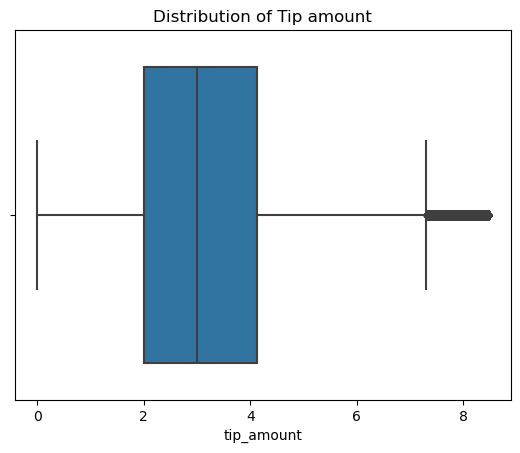

In [216]:
# Check outliers 
# The quartiles and median are very close together. 
# Reasons behind this 1. the large data set and tight distribution 2. the values in the tip_amount column have a very narrow range
sns.boxplot(x = data['tip_amount'])
plt.title('Distribution of Tip amount')

plt.show()

In [218]:
# EXTRA
# compare no-tippers, non_generous, and generous tippers
# Define bins and labels for the tip categories
bins = [-1, 0, 20, float('inf')]  # Bins for $0 tippers, <=20 tippers, >20 tippers
labels = ['no_tippers', 'non_generous', 'generous']  # Labels for the bins

# Use pd.cut to categorize tips into 3 categories
data['tip_category'] = pd.cut(data['tip_percent'], bins=bins, labels=labels)

data.tip_category.value_counts()

tip_category
generous        929001
non_generous    365634
no_tippers       70708
Name: count, dtype: int64

In [220]:
# Percentage tipping, non tipping customers
tippers, non_tippers = (data.tip_generosity.value_counts(normalize = True)* 100).round(1)

gen_tippers = (data.tip_category.value_counts(normalize = True).iloc[0]* 100).round(1)
non_gen_tippers = (data.tip_category.value_counts(normalize= True).iloc[1]* 100).round(1)
no_tippers = (data.tip_category.value_counts(normalize = True).iloc[2]* 100).round(1)
total_customers = len(data)

<Figure size 800x600 with 0 Axes>

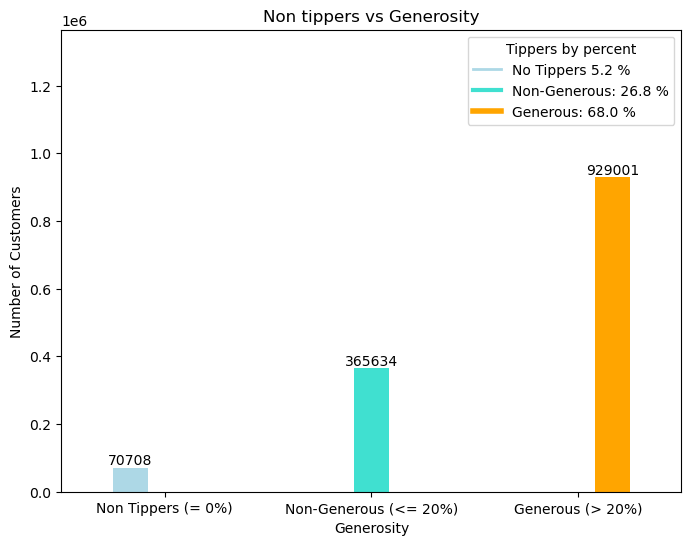

In [222]:
plt.figure(figsize=(8, 6))
axes = pd.crosstab(data['tip_category'],data['tip_category']).plot(kind='bar',  
                                                       color=['lightblue', 'Turquoise', 'orange' ],figsize = (8, 6))
plt.title('Non tippers vs Generosity')
plt.xlabel('Generosity')
plt.xticks([0, 1, 2 ],['Non Tippers (= 0%)', 'Non-Generous (<= 20%)', 'Generous (> 20%)'], rotation = 0)

# Add counts on top of the bars
for bar in axes.patches:
    yval = bar.get_height()  # Define yval here
    if yval != 0:  # Check if yval is not zero
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom')



plt.ylim(0, total_customers)  # Set Y-axis limits to total number of tippers
plt.ylabel('Number of Customers')

handles = [plt.Line2D([0],[0], color = 'lightblue', lw = 2 ),
           plt.Line2D([0], [0], color = 'Turquoise' , lw = 3),
           plt.Line2D([0], [0], color = 'orange' , lw = 4),
          ]

labels = [ f'No Tippers {no_tippers} %', f'Non-Generous: {non_gen_tippers} %', f'Generous: {gen_tippers} %']

plt.legend(handles, labels, title='Tippers by percent', loc = 'best')
plt.show()

<Figure size 800x500 with 0 Axes>

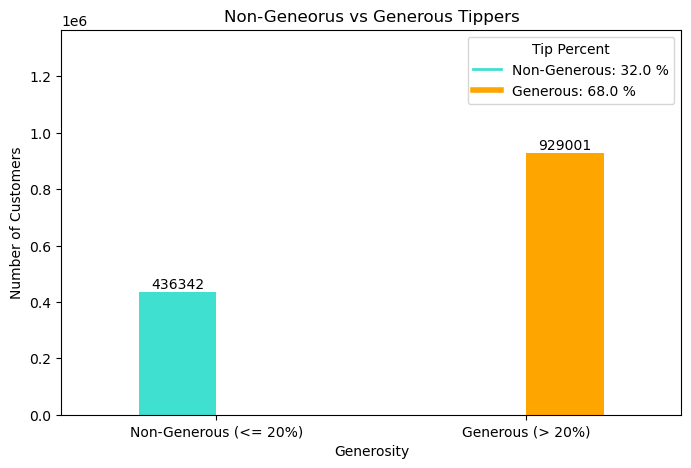

In [224]:
# Plot Non-Geneorus(including $0 tips) vs Generous customers
plt.figure(figsize=(8, 5))
axes = pd.crosstab(data['tip_generosity'],data['tip_generosity']).plot(kind='bar',  
                                                        color=['Turquoise', 'orange'],figsize = (8, 5))
plt.title('Non-Geneorus vs Generous Tippers')
plt.xlabel('Generosity')
plt.xticks([0, 1 ],['Non-Generous (<= 20%)', 'Generous (> 20%)'], rotation = 0)

plt.ylim(0, total_customers)  # Set Y-axis limits to total number of tippers
plt.ylabel('Number of Customers')

# Add counts on top of the bars
for bar in axes.patches:
    yval = bar.get_height()  # Define yval here
    if yval != 0:  # Check if yval is not zero
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom')

handles = [plt.Line2D([0],[0], color = 'Turquoise', lw = 2 ),
           plt.Line2D([0], [0], color = 'orange' , lw = 4)
          ]
labels = [ f'Non-Generous: { non_tippers} %', f'Generous: {tippers} %']

plt.legend(handles, labels, title='Tip Percent', loc = 'best')
plt.show()


In [226]:
# NEW DataFrame here
###
data_fnl = data.copy()


In [228]:
# night_ride -> -float('inf') to 6 -> Midnight (12:00 AM) to just before 6 AM
# am_rush -> 6 AM to just before 9 AM day_ride -> 9 AM to just before 5 PM (17:00)
# pm_rush -> 5 PM (17:00) to just before 9 PM (21:00)
# evening_ride 9 PM (21:00) to midnight and beyond



bins = [-float('inf'), 6, 9, 17, 21, float('inf')]
labels = ['night_ride', 'am_rush', 'day_ride', 'pm_rush', 'evening_ride']

data_fnl['hours_category'] = pd.cut(data_fnl['pickup_hour'], bins = bins, labels = labels)

data_fnl.hours_category.value_counts()


hours_category
day_ride        603155
pm_rush         266805
evening_ride    168426
am_rush         166470
night_ride      160487
Name: count, dtype: int64

In [230]:
data_fnl

,pickup_date,pickup_hour,trip_distance,fare_amount,extra,tip_amount,congestion_surcharge,total_amount,trip_duration_min,trip_duration_hr,pickup_weekday,pickup_day,tip_percent,tip_generosity,tip_category,hours_category
0,2024-06-01,0,1.30,10.0,1.0,3.10,0.0,15.60,8.70,0.145000,5,Saturday,28.18,1,generous,night_ride
1,2024-06-01,0,1.50,11.4,1.0,2.00,2.5,18.40,11.13,0.185500,5,Saturday,13.42,0,non_generous,night_ride
2,2024-06-01,0,18.41,70.0,0.0,0.15,2.5,82.84,56.73,0.945500,5,Saturday,0.21,0,non_generous,night_ride
3,2024-06-01,0,0.74,6.5,1.0,2.30,2.5,13.80,5.03,0.083833,5,Saturday,23.00,1,generous,night_ride
4,2024-06-01,0,1.78,17.7,1.0,1.00,2.5,23.70,20.12,0.335333,5,Saturday,4.72,0,non_generous,night_ride
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365338,2024-06-30,23,1.53,9.3,1.0,0.00,2.5,14.30,6.52,0.108667,6,Sunday,0.00,0,no_tippers,evening_ride
1365339,2024-06-30,23,1.71,10.0,1.0,0.00,2.5,15.00,7.00,0.116667,6,Sunday,0.00,0,no_tippers,evening_ride
1365340,2024-06-30,23,2.29,12.1,1.0,2.56,2.5,19.66,8.52,0.142000,6,Sunday,16.41,0,non_generous,evening_ride
1365341,2024-06-30,23,1.36,18.4,1.0,4.68,2.5,28.08,21.03,0.350500,6,Sunday,21.37,1,generous,evening_ride


In [232]:
# Count and summarize the 'tip_categor'y within each 'hours_category'
group1 = data_fnl.groupby('hours_category')['tip_category'].value_counts()
group1


hours_category  tip_category
night_ride      generous        100770
                non_generous     44953
                no_tippers       14764
am_rush         generous        111877
                non_generous     48038
                no_tippers        6555
day_ride        generous        423684
                non_generous    152449
                no_tippers       27022
pm_rush         generous        180997
                non_generous     72776
                no_tippers       13032
evening_ride    generous        111673
                non_generous     47418
                no_tippers        9335
Name: count, dtype: int64

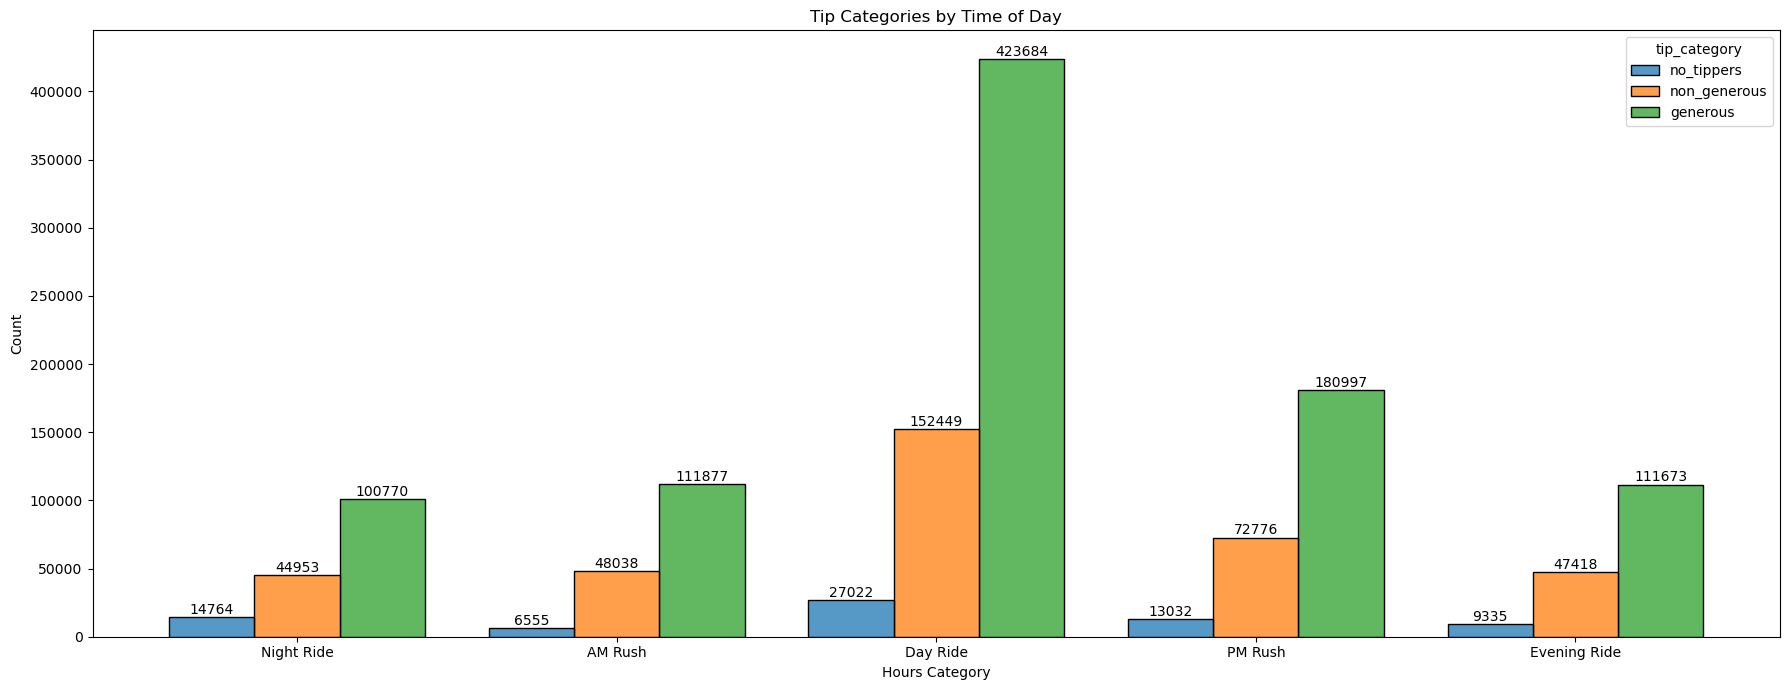

In [234]:
# Distrubition of tippers by time of day
plt.figure(figsize = (18, 7))
axes = sns.histplot(data=data_fnl, x='hours_category', hue='tip_category', multiple='dodge', shrink= 0.8) 

# Add counts on top of the bars
for bar in axes.patches:
    yval = bar.get_height()  # Define yval here
    if yval != 0:  # Check if yval is not zero
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom')


plt.title('Tip Categories by Time of Day')
plt.xlabel('Hours Category')
plt.xticks( [0, 1, 2, 3, 4], ['Night Ride', 'AM Rush', 'Day Ride', 'PM Rush', 'Evening Ride'] )

plt.tight_layout()
plt.show()

In [236]:
# The day_ride and pm_rush periods have the most trips overall, with generous tippers being the largest group during these times.
# am_rush and night_ride periods show fewer trips, with non-generous and no tippers having more activity here compared to the peak periods.

#This plot provides a clear comparison of tipping behavior across time periods, making it easier to see where and when tipping occurs the most. ​

In [238]:
# Final check if caught more outliers
data_fnl.describe()

,pickup_hour,trip_distance,fare_amount,extra,tip_amount,congestion_surcharge,total_amount,trip_duration_min,trip_duration_hr,pickup_weekday,tip_percent,tip_generosity
count,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06,1.365343e+06
mean,1.367855e+01,2.276359e+00,1.518832e+01,3.691674e-01,3.179520e+00,2.415324e+00,2.278712e+01,1.424494e+01,2.374157e-01,3.338368e+00,1.913279e+01,6.804158e-01
std,6.333087e+00,5.273012e+01,1.136095e+01,4.825781e-01,1.716010e+00,4.522364e-01,1.255775e+01,3.761932e+01,6.269886e-01,1.980750e+00,7.883127e+00,4.663156e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,1.000000e+00,8.600000e+00,0.000000e+00,2.000000e+00,2.500000e+00,1.548000e+01,7.130000e+00,1.188333e-01,2.000000e+00,1.590000e+01,0.000000e+00
50%,1.400000e+01,1.600000e+00,1.280000e+01,0.000000e+00,3.000000e+00,2.500000e+00,1.980000e+01,1.128000e+01,1.880000e-01,3.000000e+00,2.160000e+01,1.000000e+00
75%,2.000000e+01,2.590000e+00,1.840000e+01,1.000000e+00,4.120000e+00,2.500000e+00,2.640000e+01,1.723000e+01,2.871667e-01,5.000000e+00,2.263000e+01,1.000000e+00
max,2.300000e+01,6.131285e+04,5.000000e+02,1.000000e+00,8.470000e+00,2.500000e+00,5.163800e+02,1.439680e+03,2.399467e+01,6.000000e+00,6.000000e+02,1.000000e+00


In [240]:
# Possssible outliers spotted under 'trip_distance', 'fare_amount', 'exta', 'total_amount' and 'tip_percent'columns
# Compute Q1 (25th percentile) and Q3 (75th percentile)
# _td = trip_distance

Q1_td = data_fnl['trip_distance'].quantile(0.25)
Q3_td = data_fnl['trip_distance'].quantile(0.75)

IQR_td = Q3_td - Q1_td 

lower_bound_td = (Q1_td - 1.5) * IQR_td
upper_bound_td = (Q3_td + 1.5) * IQR_td

# Identify outliers
outliers_td = data_fnl[(data_fnl['trip_distance'] < lower_bound_td) | (data_fnl['trip_distance'] > upper_bound_td)]


In [242]:
# Print the number of outliers and some sample rows
print(f"\n{RED}Number of outliers under 'trip_distance': {RESET}{len(outliers_td)}\n")



Number of outliers under 'trip_distance': 46665



In [244]:
# Very high... so we need to use a different method in the next cell
print(lower_bound_td)
print(upper_bound_td)

-0.7949999999999999
6.503099999999999


In [246]:
# Remove outliers from the dataset
print(f'Before removaloutliers in extra column: {RED}{data_fnl.shape[0]}{RESET}')
data_fnl = data_fnl[(data_fnl['trip_distance'] >= lower_bound_td) & (data_fnl['trip_distance'] <= upper_bound_td)].reset_index(drop = True)
print(f'After removal outliers in extra column : {RED} {data_fnl.shape[0]}{RESET}')

Before removaloutliers in extra column: 1365343
After removal outliers in extra column :  1318678


In [248]:
# Another outlier problem here.
# Max tip percent is $600 
data_fnl.tip_percent.describe()

count    1.318678e+06
mean     1.944294e+01
std      7.694011e+00
min      0.000000e+00
25%      1.635000e+01
50%      2.166000e+01
75%      2.263000e+01
max      6.000000e+02
Name: tip_percent, dtype: float64

In [250]:
# Remove entries where 'tip_percent' is greater 50% threshold in ordert to get rid of outliers
print(f'{RED}Before removal at 50% treshold : {RESET}{data_fnl.shape[0]}')
data_fnl = data_fnl[data_fnl['tip_percent'] <= 50].reset_index(drop = True)
print(f'{RED}After removal at 50% treshold : {RESET}{data_fnl.shape[0]}')

Before removal at 50% treshold : 1318678
After removal at 50% treshold : 1316548


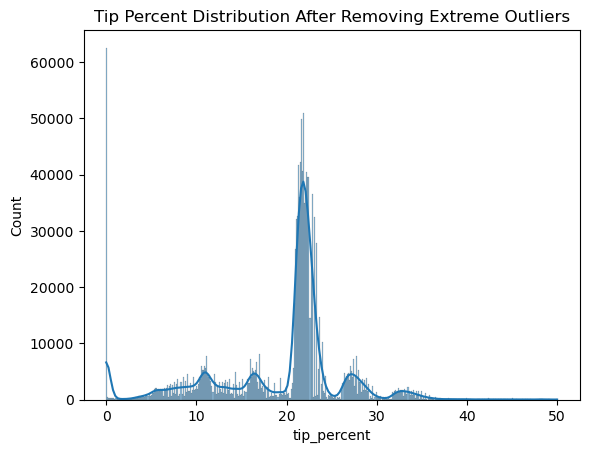

In [252]:
# Visualize the cleaned 'tip_percent' data
sns.histplot(data_fnl['tip_percent'], kde=True)
plt.title('Tip Percent Distribution After Removing Extreme Outliers')
plt.show()


In [937]:
data_am_pm = data_fnl.copy()

In [938]:
# Define a function to convert pickup_hour to AM/PM format
def convert_to_ampm(hour):
    if hour == 12:
        return "12 PM"
    elif hour == 0:
        return "12 AM"
    elif hour < 12:
        return f"{hour} AM"
    else:
        return f"{hour-12} PM"
 
# Apply the function to the pickup_hour column
data_am_pm['pickup_hour'] = data_am_pm['pickup_hour'].apply(convert_to_ampm)


In [941]:
data_fnl['pickup_hr'] = data_fnl['pickup_hour'].sort_index()


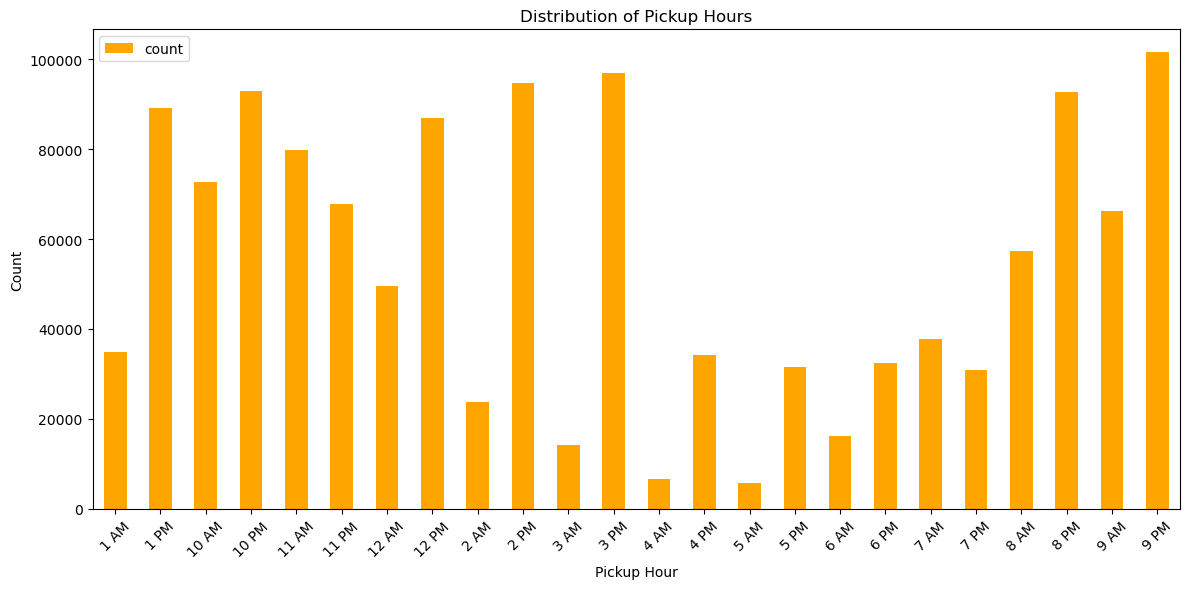

In [943]:

plt.figure(figsize=(12, 6))
pd.crosstab(data_am_pm.pickup_hour, columns="count").plot(kind='bar', color = 'orange' ,  ax=plt.gca())

plt.title('Distribution of Pickup Hours')
plt.xlabel('Pickup Hour')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

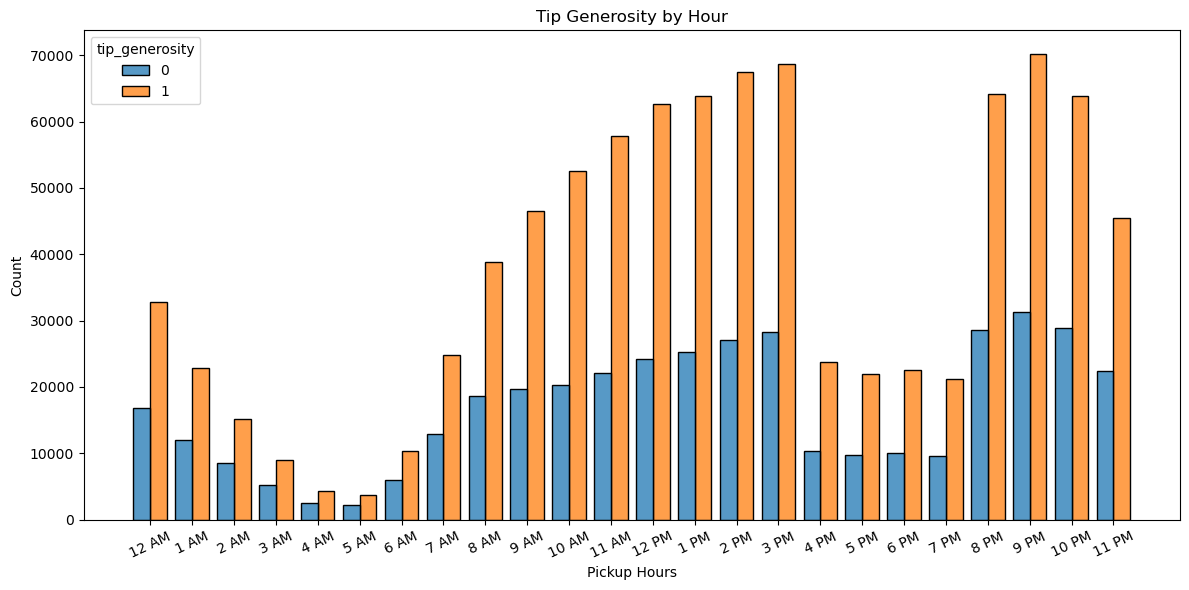

In [945]:
# Distrubition of tippers by time of day
plt.figure(figsize = (12, 6))
hour_order = [
    "12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM", 
    "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"
            ]

# Convert 'pickup_hour' column to categorical type with the specified order
data_am_pm['pickup_hour'] = pd.Categorical(data_am_pm['pickup_hour'], categories = hour_order, ordered=True)

sns.histplot(data=data_am_pm, x='pickup_hour', hue='tip_generosity', multiple='dodge', shrink = 0.8) 

plt.title('Tip Generosity by Hour')
plt.xlabel('Pickup Hours')
plt.xticks(rotation = 25)


plt.tight_layout()
plt.show()

In [947]:
data_am_pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316548 entries, 0 to 1316547
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   pickup_date           1316548 non-null  object  
 1   pickup_hour           1316548 non-null  category
 2   trip_distance         1316548 non-null  float64 
 3   fare_amount           1316548 non-null  float64 
 4   extra                 1316548 non-null  float64 
 5   tip_amount            1316548 non-null  float64 
 6   congestion_surcharge  1316548 non-null  float64 
 7   total_amount          1316548 non-null  float64 
 8   trip_duration_min     1316548 non-null  float64 
 9   trip_duration_hr      1316548 non-null  float64 
 10  pickup_weekday        1316548 non-null  int32   
 11  pickup_day            1316548 non-null  object  
 12  tip_percent           1316548 non-null  float64 
 13  tip_generosity        1316548 non-null  int64   
 14  tip_category      

In [949]:
#pickup_hr = data_am_pm.pickup_hr.sort_index()
data_am_pm.pickup_hour.value_counts().sort_index()


pickup_hour
12 AM     49604
1 AM      34889
2 AM      23695
3 AM      14186
4 AM       6755
5 AM       5865
6 AM      16239
7 AM      37672
8 AM      57366
9 AM      66164
10 AM     72752
11 AM     79820
12 PM     86881
1 PM      89070
2 PM      94661
3 PM      96893
4 PM      34128
5 PM      31661
6 PM      32526
7 PM      30862
8 PM      92613
9 PM     101525
10 PM     92867
11 PM     67854
Name: count, dtype: int64

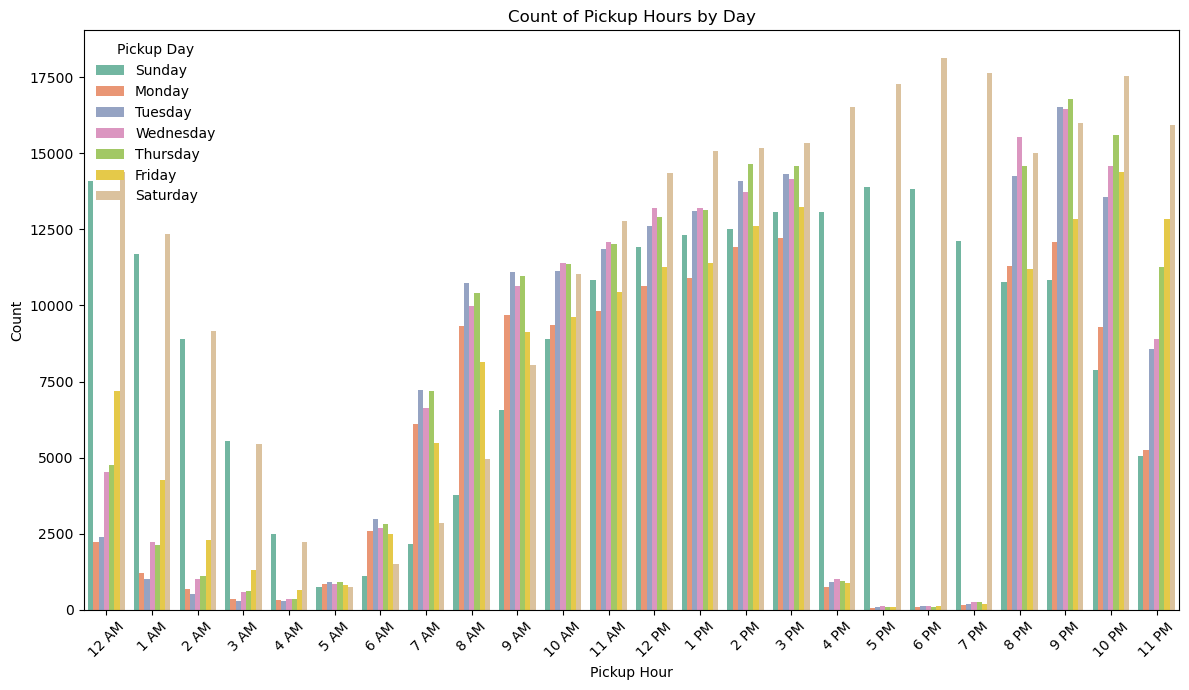

In [951]:


weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
data_am_pm['pickup_day'] = pd.Categorical(data_am_pm['pickup_day'], categories = weekdays, ordered=True)

# Count plot for pickup hours by day
plt.figure(figsize=(12, 7))
sns.countplot(data=data_am_pm, x='pickup_hour', hue='pickup_day', palette='Set2')

# Set title and labels
plt.title('Count of Pickup Hours by Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add a legend with a title and adjust its position
plt.legend(title='Pickup Day', loc='upper left', bbox_to_anchor=(0, 1), frameon=False)

plt.tight_layout()
plt.show()


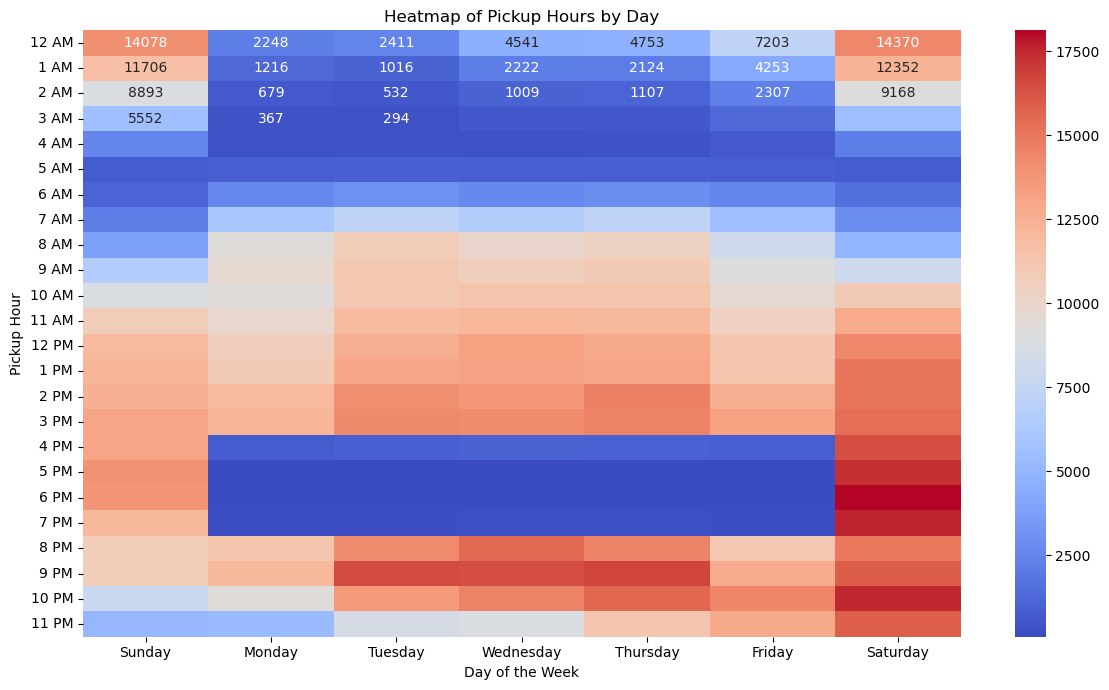

In [955]:
pickup_pivot = pd.crosstab(data_am_pm['pickup_hour'], data_am_pm['pickup_day'])

# Generate the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(pickup_pivot, cmap='coolwarm', annot=True, fmt='g')

# Set title and labels
plt.title('Heatmap of Pickup Hours by Day')
plt.xlabel('Day of the Week')
plt.ylabel('Pickup Hour')

plt.tight_layout()
plt.show()



In [1021]:
# More outliers here.
data_fnl[['fare_amount','total_amount', 'trip_distance', 'trip_duration_min', 'trip_duration_hr']].describe()

,fare_amount,total_amount,trip_distance,trip_duration_min,trip_duration_hr
count,1.316548e+06,1.316548e+06,1.316548e+06,1.316548e+06,1.316548e+06
mean,1.390996e+01,2.137488e+01,1.888174e+00,1.343277e+01,2.238796e-01
std,7.813948e+00,8.779635e+00,1.248064e+00,3.632536e+01,6.054226e-01
min,0.000000e+00,1.010000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.600000e+00,1.547000e+01,9.900000e-01,7.020000e+00,1.170000e-01
50%,1.210000e+01,1.950000e+01,1.550000e+00,1.098000e+01,1.830000e-01
75%,1.700000e+01,2.540000e+01,2.450000e+00,1.650000e+01,2.750000e-01
max,4.350000e+02,4.360000e+02,6.500000e+00,1.439680e+03,2.399467e+01


In [1023]:
# Max 'total_amount' showing for $436 but the 'trip_distance' is 0
data_fnl.loc[(data_fnl.total_amount == 436), ['total_amount', 'trip_distance', 'trip_duration_min', 'trip_duration_hr'] ]


,total_amount,trip_distance,trip_duration_min,trip_duration_hr
1025688,436.0,0.0,0.08,0.001333


In [1025]:
# Max 'trip_duration_min' showing for $1439.88 but the 'trip_distance' is 1.1 ,=miles so this doesb't make sense as well 
data_fnl.loc[(data_fnl.trip_duration_min == 1439.68), ['total_amount', 'trip_distance', 'trip_duration_min', 'trip_duration_hr'] ]


,total_amount,trip_distance,trip_duration_min,trip_duration_hr
62530,18.5,1.1,1439.68,23.994667


In [1027]:
# Check total number of 'trip_distance' where values 0 

data_fnl.trip_distance[data_fnl.trip_distance == 0].count()

10614

In [1029]:
# Filter more data using SQLite
####

In [1031]:
# Create an SQLite database stored in a file
database_path = '/tmp/my_database.db'  # Choose a file path
if os.path.exists(database_path):
    os.remove(database_path)  # Remove the file if it already exists

conn = sqlite3.connect(database_path)  # Create a file-based SQLite database

# Load data_fnl into SQLite
data_fnl.to_sql('data_fnl', conn, if_exists='replace', index=False)
conn.close()  # Close the connection


In [1033]:

%sql sqlite:////tmp/my_database.db

In [1035]:
%%sql
SELECT trip_distance, fare_amount, total_amount, trip_duration_hr FROM data_fnl
ORDER BY trip_distance DESC
LIMIT 10

 * sqlite:////tmp/my_database.db
Done.


trip_distance,fare_amount,total_amount,trip_duration_hr
6.5,37.3,49.56,0.588
6.5,37.3,41.3,0.6196666666666667
6.5,31.7,42.84,0.41133333333333333
6.5,44.3,49.3,0.853
6.5,55.0,56.0,0.442
6.5,35.2,48.24,0.5436666666666666
6.5,31.7,44.04,0.4116666666666667
6.5,34.5,39.5,0.5261666666666667
6.5,31.0,42.0,0.37583333333333335
6.5,31.7,38.7,0.4245


In [1037]:
# Check 'trip_distance' in sql where values 0 

In [1039]:
%%sql
SELECT fare_amount, total_amount, trip_distance, tip_amount, COUNT(*) OVER() AS total_count
FROM data_fnl 
WHERE trip_distance = 0
ORDER BY total_amount DESC
LIMIT 10


 * sqlite:////tmp/my_database.db
Done.


fare_amount,total_amount,trip_distance,tip_amount,total_count
435.0,436.0,0.0,0.0,10614
434.0,435.0,0.0,0.0,10614
410.0,411.0,0.0,0.0,10614
400.0,403.5,0.0,0.0,10614
400.0,401.0,0.0,0.0,10614
362.0,368.0,0.0,5.0,10614
350.0,353.5,0.0,0.0,10614
350.0,351.4,0.0,0.4,10614
350.0,351.0,0.0,0.0,10614
350.0,351.0,0.0,0.0,10614


In [1041]:
# Remove 'trip_distance' where values are 0 
# total 10614 rows need to be removed
print(f'Before removal of 10,614 entries:{RED}{data_fnl.shape[0]}{RESET}')
data_fnl = data_fnl[data_fnl.trip_distance != 0].reset_index(drop = True)
print(f'After removal:{RED} {data_fnl.shape[0]}{RESET}')

Before removal of 10,614 entries:1316548
After removal: 1305934


In [1043]:
%%sql
SELECT trip_duration_min, trip_duration_hr, trip_distance, fare_amount, total_amount 
FROM data_fnl
ORDER BY trip_duration_min DESC
LIMIT 10

 * sqlite:////tmp/my_database.db
Done.


trip_duration_min,trip_duration_hr,trip_distance,fare_amount,total_amount
1439.68,23.994666666666667,1.1,13.5,18.5
1439.4,23.990000000000002,1.42,13.5,21.88
1439.28,23.988,0.42,4.4,9.4
1439.25,23.9875,2.76,24.0,28.0
1439.18,23.986333333333334,3.26,19.8,24.8
1439.17,23.98616666666667,3.23,19.1,24.1
1439.15,23.985833333333336,1.85,11.4,17.71
1439.05,23.984166666666667,1.39,8.6,14.49
1439.05,23.984166666666667,2.64,18.4,28.08
1438.98,23.983,3.36,20.5,30.6


In [1045]:
data_fnl.trip_duration_min.describe()

count    1.305934e+06
mean     1.347011e+01
std      3.635390e+01
min      0.000000e+00
25%      7.070000e+00
50%      1.102000e+01
75%      1.652000e+01
max      1.439680e+03
Name: trip_duration_min, dtype: float64

In [1047]:
# Q1 (25%) and Q3 (75%) percentile 
# _tdm = trip_duration_min
Q1_tdm = data_fnl.trip_duration_min.quantile(0.25)
Q3_tdm = data_fnl.trip_duration_min.quantile(0.75)

IQR_tdm = Q3_tdm - Q1_tdm

lower_bound_tdm = Q1_tdm - 1.5 * IQR_tdm
upper_bound_tdm = Q3_tdm + 1.5 * IQR_tdm
outliers_tdm = data_fnl[(data_fnl.trip_duration_min <= lower_bound_tdm) | (data_fnl.trip_duration_min >= upper_bound_tdm)]
print(lower_bound_tdm)
print(upper_bound_tdm)
print(f'{RED}Total number of outliers: {outliers_tdm.shape[0]}')

-7.104999999999999
30.695
Total number of outliers: 32780


In [1049]:
# Remove outliers
print(f'{RED}Before removing : {data_fnl.shape[0]}')
data_fnl = data_fnl[(data_fnl.trip_duration_min >= lower_bound_tdm) & (data_fnl.trip_duration_min <= upper_bound_tdm)]
print(f'After removing : {data_fnl.shape[0]}')

Before removing : 1305934
After removing : 1273154


In [1051]:
data_fnl = data_fnl.reset_index(drop = True)

In [1053]:
# Comparte tip amount vs total_amount

In [1057]:
# Now our data is clean

data_heatmap = data_fnl.copy()

data_heatmap = data_heatmap.drop(['pickup_date', 'tip_category', 'congestion_surcharge', 'tip_percent'], axis = 1).reset_index(drop = True)
                              

In [1059]:
data_heatmap.dtypes

pickup_hour             int64
trip_distance         float64
fare_amount           float64
extra                 float64
tip_amount            float64
total_amount          float64
trip_duration_min     float64
trip_duration_hr      float64
pickup_weekday          int32
pickup_day             object
tip_generosity          int64
hours_category       category
pickup_hr               int64
dtype: object

In [1061]:
dummies = pd.get_dummies(data_heatmap['hours_category']).reset_index(drop = True).astype(int)
data_heatmap = pd.concat([data_heatmap, dummies], axis = 1)

data_heatmap = data_heatmap.drop(columns = 'hours_category', axis = 1).reset_index(drop = True)

In [1063]:
data_heatmap

,pickup_hour,trip_distance,fare_amount,extra,tip_amount,total_amount,trip_duration_min,trip_duration_hr,pickup_weekday,pickup_day,tip_generosity,pickup_hr,night_ride,am_rush,day_ride,pm_rush,evening_ride
0,0,1.30,10.0,1.0,3.10,15.60,8.70,0.145000,5,Saturday,1,0,1,0,0,0,0
1,0,1.50,11.4,1.0,2.00,18.40,11.13,0.185500,5,Saturday,0,0,1,0,0,0,0
2,0,0.74,6.5,1.0,2.30,13.80,5.03,0.083833,5,Saturday,1,0,1,0,0,0,0
3,0,1.78,17.7,1.0,1.00,23.70,20.12,0.335333,5,Saturday,0,0,1,0,0,0,0
4,0,2.94,15.6,1.0,5.15,25.75,11.73,0.195500,5,Saturday,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273149,23,1.53,9.3,1.0,0.00,14.30,6.52,0.108667,6,Sunday,0,23,0,0,0,0,1
1273150,23,1.71,10.0,1.0,0.00,15.00,7.00,0.116667,6,Sunday,0,23,0,0,0,0,1
1273151,23,2.29,12.1,1.0,2.56,19.66,8.52,0.142000,6,Sunday,0,23,0,0,0,0,1
1273152,23,1.36,18.4,1.0,4.68,28.08,21.03,0.350500,6,Sunday,1,23,0,0,0,0,1


In [1161]:
corr_matrix = data_heatmap[['pickup_hour','trip_duration_min', 'trip_distance', 'fare_amount', 'pickup_weekday',
                           'tip_generosity', 'night_ride', 'am_rush', 'day_ride', 'pm_rush', 'evening_ride']].corr()

corr_matrix = round((corr_matrix *100),2)
corr_matrix

,pickup_hour,trip_duration_min,trip_distance,fare_amount,pickup_weekday,tip_generosity,night_ride,am_rush,day_ride,pm_rush,evening_ride
pickup_hour,100.00,6.08,1.17,3.26,-5.13,1.33,-67.87,-32.74,-8.44,49.59,51.72
trip_duration_min,6.08,100.00,71.17,86.96,-4.03,-2.06,-9.08,-3.85,8.04,0.13,0.42
trip_distance,1.17,71.17,100.00,82.88,3.94,-4.06,9.30,-2.51,-12.80,3.63,8.38
fare_amount,3.26,86.96,82.88,100.00,-0.79,-4.61,-1.23,-3.12,0.16,0.86,3.03
pickup_weekday,-5.13,-4.03,3.94,-0.79,100.00,-1.71,16.84,-14.35,-2.20,4.44,-4.12
tip_generosity,1.33,-2.06,-4.06,-4.61,-1.71,100.00,-3.59,-1.04,4.04,-0.31,-1.19
night_ride,-67.87,-9.08,9.30,-1.23,16.84,-3.59,100.00,-13.62,-32.15,-17.96,-13.60
am_rush,-32.74,-3.85,-2.51,-3.12,-14.35,-1.04,-13.62,100.00,-33.29,-18.59,-14.08
day_ride,-8.44,8.04,-12.80,0.16,-2.20,4.04,-32.15,-33.29,100.00,-43.89,-33.23
pm_rush,49.59,0.13,3.63,0.86,4.44,-0.31,-17.96,-18.59,-43.89,100.00,-18.56


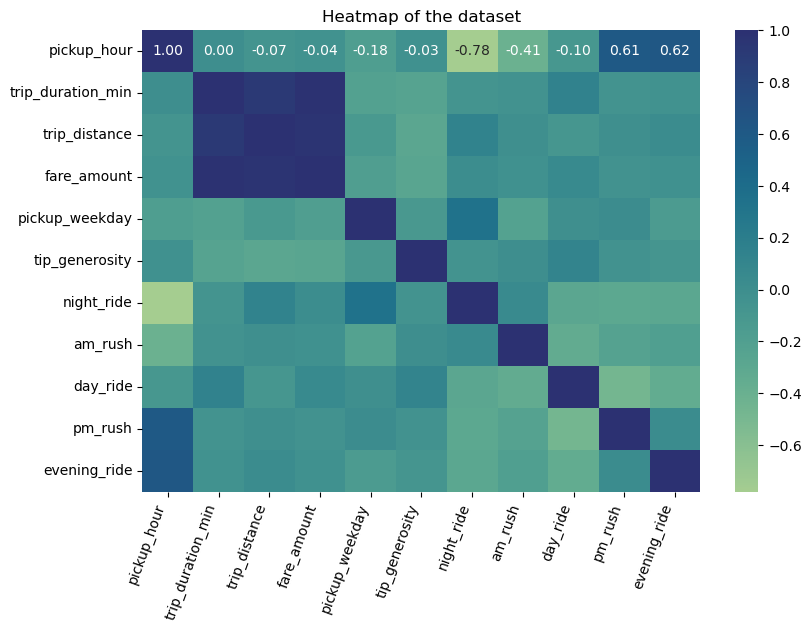

In [1163]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(9, 6))

sns.heatmap(corr_matrix.corr(), annot=True, cmap = 'crest', fmt='.2f')
plt.xticks(rotation=70, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Heatmap of the dataset')
plt.show()


In [1079]:
# Very weak positive correlation; day_ride (%4.04) has a slight effect on tip generosity.
# Weak Correlations: Most correlations are very weak (close to 0), indicating that the variables do not strongly influence each other.
# Moderate Correlation: The strongest correlation here is between trip_duration_min and fare_amount (%86,6), 
# suggesting that longer trips tend to result in higher fares.

In [1091]:
# Check the dataset is in balance 
print(data_heatmap['tip_generosity'].value_counts(normalize = True))


tip_generosity
1    0.698847
0    0.301153
Name: proportion, dtype: float64


In [1095]:
# Define the X (predictor) an y variables
# Adjusting the model parameters and removing tip_amount, total_amount, tip_generosity, 
# and tip_percent in order to significantly improve our model’s performance here
# Otherwie models prediction scores are all close to 1.0s or 1.0s. 
y = data_heatmap['tip_generosity']
X = data_heatmap.copy()
X = X.drop(columns= ['tip_amount','total_amount', 'tip_generosity', 'trip_distance', 'trip_duration_hr', 'pickup_day'], axis = 1).reset_index(drop = True)

In [1097]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273154 entries, 0 to 1273153
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pickup_hour        1273154 non-null  int64  
 1   fare_amount        1273154 non-null  float64
 2   extra              1273154 non-null  float64
 3   trip_duration_min  1273154 non-null  float64
 4   pickup_weekday     1273154 non-null  int32  
 5   pickup_hr          1273154 non-null  int64  
 6   night_ride         1273154 non-null  int64  
 7   am_rush            1273154 non-null  int64  
 8   day_ride           1273154 non-null  int64  
 9   pm_rush            1273154 non-null  int64  
 10  evening_ride       1273154 non-null  int64  
dtypes: float64(3), int32(1), int64(7)
memory usage: 102.0 MB


In [1099]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)


In [1101]:
%%time
# Define  parameter grid for the decision tree. These are the best parameters
# Initialize the Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=0)

cv_params = {
    'min_samples_split': [3, 10],   
    'max_depth': [10],   
    'min_samples_leaf': [2],
    'criterion': ['gini'], 
    'max_features': ['sqrt'],
            }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Initialize GridSearchCV with the decision tree, hyperparameters, and scoring metric
dt_cv = GridSearchCV(dt, cv_params, scoring=scoring, cv=5, refit='f1', error_score='raise')

# Fit the model to training data
dt_cv.fit(X_train, y_train)


CPU times: user 6.39 s, sys: 359 ms, total: 6.75 s
Wall time: 6.9 s


GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini'], 'max_depth': [10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'min_samples_split': [3, 10]},
             refit='f1',
             scoring={'recall', 'f1', 'accuracy', 'precision', 'roc_auc'})

In [1102]:
#Predict the model
dt_pred = dt_cv.predict(X_test)
print(dt_pred)

[1 1 1 ... 1 1 1]


In [1103]:
print(f'Best parameters: "{dt_cv.best_params_}')

Best parameters: "{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}


In [1104]:
print('Besgt f1 score: ' '%.3f' % dt_cv.best_score_)

Besgt f1 score: 0.823


In [1105]:
# 'make_results' Accepts as arguments a model name and a fit GridSearchCV model object
# Returns a pandas df with the F1, recall, precision, and accuracy scores 
# for the model with the best mean F1 score across all validation folds.

def make_results(model_name:str, model_object):

        # Get all the results from the CV and put them in a df
        cv_results = pd.DataFrame(model_object.cv_results_)

        # Isolate the row of the df with the max(mean f1 score)
        #best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax()]
        # Isolate the row of the df with the max(mean f1 score)
        best_estimator_index = cv_results['mean_test_f1'].idxmax()
        best_estimator_results = cv_results.iloc[best_estimator_index]

    
        # Extract accuracy, precision, recall, and f1 score from that row
        f1 = best_estimator_results.mean_test_f1
        recall = best_estimator_results.mean_test_recall
        precision = best_estimator_results.mean_test_precision
        accuracy = best_estimator_results.mean_test_accuracy
        auc = best_estimator_results.get('mean_test_roc_auc', None)
        # Create table of results
        table = pd.DataFrame({'Model': [model_name],
                              'F1': [f1],
                              'Recall': [recall],
                              'Precision': [precision],
                              'Accuracy': [accuracy],
                              'Auc': [auc]
                              })

        return table


In [1106]:
dt_cv_results = make_results('Decision Tree CV', dt_cv)
dt_cv_results = pd.DataFrame(dt_cv_results)


In [1107]:
dt_cv_results

,Model,F1,Recall,Precision,Accuracy,Auc
0,Decision Tree CV,0.822779,0.998491,0.699656,0.699401,0.538591


In [1112]:
%%time
# Perform 5-fold cross-validation
cv_scores = cross_val_score(dt_cv, X, y, cv=3)

# Print the average cross-validation score
print("Cross-Validation Accuracy: %.3f" % cv_scores.mean())


Cross-Validation Accuracy: 0.823
CPU times: user 15.2 s, sys: 1.01 s, total: 16.2 s
Wall time: 16.8 s


In [1116]:
# The Cross-validation accuracy of 0.823 shows that, on average, our model was correctly classifying nearly 82.3% of samples across validation folds.
# F1 (0.822) being close or same to the cross-validation accuracy shows that the model is fairly balanced in terms of precision and recall.

In [1117]:
%%time
# Random Forest test
# I used minimal parameters here because the fact that it takes hours to compute. This parmaeters take about 10 min to compute
# We use the `%%time` magic at the top of the cell. This outputs the final runtime of the cell
rf = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth': [10],
             'max_features': ['auto'],
             'max_samples': [1.0],
             'min_samples_leaf': [6],
             'min_samples_split': [5],
             'n_estimators': [300]
            }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')
rf_cv.fit(X_train, y_train) 

CPU times: user 9min, sys: 14.8 s, total: 9min 15s
Wall time: 9min 20s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10], 'max_features': ['auto'],
                         'max_samples': [1.0], 'min_samples_leaf': [6],
                         'min_samples_split': [5], 'n_estimators': [300]},
             refit='f1',
             scoring={'recall', 'f1', 'accuracy', 'precision', 'roc_auc'})

In [1118]:
print(f'Best f1 score : {rf_cv.best_score_}')

Best f1 score : 0.8231874779025885


In [1119]:
rf_cv.best_params_


{'max_depth': 10,
 'max_features': 'auto',
 'max_samples': 1.0,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'n_estimators': 300}

In [1210]:
rf_pred = rf_cv.predict(X_test)
rf_pred

array([1, 1, 1, ..., 1, 1, 1])

In [1120]:
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results = pd.DataFrame(rf_cv_results)

In [1121]:
rf_cv_results 

,Model,F1,Recall,Precision,Accuracy,Auc
0,Random Forest CV,0.823187,0.999746,0.699631,0.699865,0.542514


In [1122]:
# Concatenate the random forest results to the master table

# Concatenating the results
results = pd.concat([dt_cv_results, rf_cv_results], ignore_index=True)
results_prev = pd.DataFrame(results)

In [1123]:
results

,Model,F1,Recall,Precision,Accuracy,Auc
0,Decision Tree CV,0.822779,0.998491,0.699656,0.699401,0.538591
1,Random Forest CV,0.823187,0.999746,0.699631,0.699865,0.542514


In [1124]:
#Random Forest CV is slightly the better model overall, as it has slightly better F1, recall,  precision, accuracy, and AUC scores.

In [1125]:
%%time
# Let's check how XGBoost to see how well the model will be performing 

xgb = XGBClassifier(random_state = 42)

cv_params = {'max_depth': [7,],
             'learning_rate': [0.1],
             'n_estimators': [700]
            }

# Define metric
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = 5, refit = 'f1')

xgb_cv.fit(X_train, y_train)


CPU times: user 4min 18s, sys: 1min 30s, total: 5min 48s
Wall time: 43.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'n_estimators': [700]},
             refit='f1',
             scoring={'recall', 'f1', 'accuracy', 'precision', 'roc_auc'})

In [1126]:
xgb_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700}

In [1127]:
print('Best f1 Score: ', '%.3f' % xgb_cv.best_score_)

Best f1 Score:  0.822


In [1128]:
xgb_cv_results = make_results('XGBooster CV', xgb_cv)
xgb_cv_results = pd.DataFrame(xgb_cv_results)

In [1129]:
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy,Auc
0,XGBooster CV,0.821973,0.995324,0.700049,0.698696,0.533155


In [1130]:
results = pd.concat([results_prev, xgb_cv_results]).reset_index(drop= True)
results = pd.DataFrame(results)

In [1131]:
results 

,Model,F1,Recall,Precision,Accuracy,Auc
0,Decision Tree CV,0.822779,0.998491,0.699656,0.699401,0.538591
1,Random Forest CV,0.823187,0.999746,0.699631,0.699865,0.542514
2,XGBooster CV,0.821973,0.995324,0.700049,0.698696,0.533155


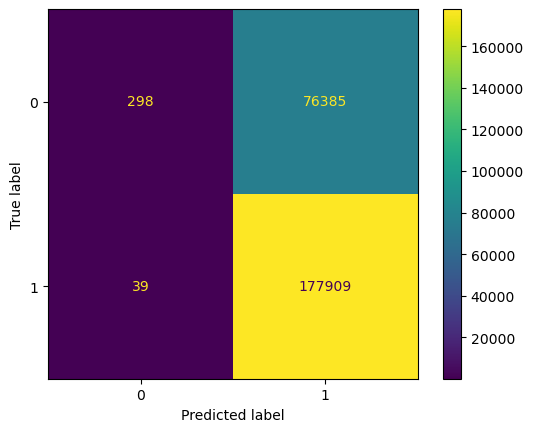

In [1279]:
# Random Forest Confusion Matrix
preds = rf_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels= rf_cv.classes_)
disp.plot(values_format='');

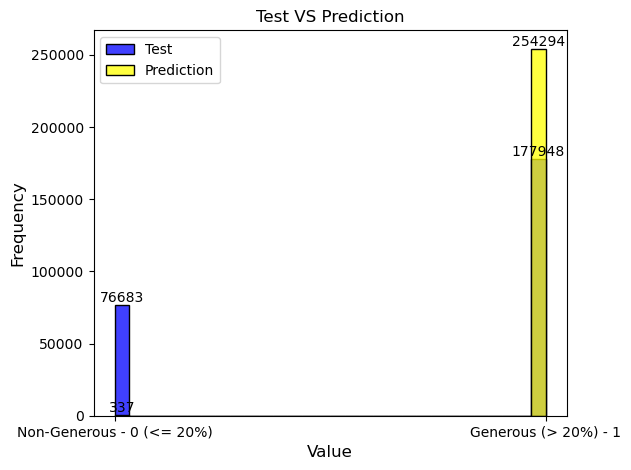

In [1307]:
#prediction vs real data using RainForest pred
sns.histplot(y_test, kde=False, color = 'blue', label = 'Test', bins=30)

# Plot the distribution of the predicted data
axes = sns.histplot(rf_pred, kde = False, color = 'yellow' , label = 'Prediction', bins=30)

# Add counts on top of the bars
for bar in axes.patches:
    yval = bar.get_height()  # Define yval here
    if yval != 0:  # Check if yval is not zero
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom')

# Set the title and labels
plt.title("Test VS Prediction")
plt.xlabel("Value", fontsize = 12)
plt.xticks([0, 1 ],['Non-Generous - 0 (<= 20%)', 'Generous (> 20%) - 1'], rotation = 0)
plt.ylabel("Frequency", fontsize = 12)
plt.legend()
plt.tight_layout()
plt.show()


In [1133]:
High FP Rate: The most concerning part of this confusion matrix is the high number of False Positives (76,385), 
meaning the model is often predicting a positive outcome when the true class is negative. 
This could cause problems in real-world applications depending on the context, as a high FP rate often indicates poor precision.

High TP Rate: On the other hand, the True Positives (177,909) are very high, meaning the model is quite 
good at detecting the positive class (high recall).

Small FN Rate: With only 44 False Negatives, the model does well at not missing positive cases, 
which is a good indicator for recall.
                         

SyntaxError: invalid syntax (2957149987.py, line 1)

In [1165]:
# Another random forest model, this time we'll tune the hyperparameters using a separate validation dataset

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.20, random_state = 10)

In [1167]:
rfc = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth': [4],
             'min_samples_leaf': [3],
             'min_samples_split': [2],
             'max_features': [2],
             'n_estimators': [200]
            }  
 
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rfc_val = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')


In [1169]:
%time
rfc_val.fit(X_train, y_train)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [4], 'max_features': [2],
                         'min_samples_leaf': [3], 'min_samples_split': [2],
                         'n_estimators': [200]},
             refit='f1',
             scoring={'recall', 'f1', 'accuracy', 'precision', 'roc_auc'})

In [1301]:
rfc_val_pred = rfc_val.predict(X_test)
rfc_val_pred 

array([1, 1, 1, ..., 1, 1, 1])

In [1170]:
print('Best f1 Score: ', '%.3f' % rfc_val.best_score_)

Best f1 Score:  0.823


In [1171]:
rfc_val.best_params_

{'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [1172]:
rfc_val_results = make_results('Random Forest Val', rfc_val) 
rfc_val_results = pd.DataFrame(rfc_val_results)

In [1173]:
rfc_val_results

,Model,F1,Recall,Precision,Accuracy,Auc
0,Random Forest Val,0.823199,0.999962,0.699541,0.699823,0.537958


In [1174]:

results = pd.concat([results, rfc_val_results]).reset_index(drop = True)
results

,Model,F1,Recall,Precision,Accuracy,Auc
0,Decision Tree CV,0.822779,0.998491,0.699656,0.699401,0.538591
1,Random Forest CV,0.823187,0.999746,0.699631,0.699865,0.542514
2,XGBooster CV,0.821973,0.995324,0.700049,0.698696,0.533155
3,Random Forest Val,0.823199,0.999962,0.699541,0.699823,0.537958


In [1175]:
# All models have similar accuracy (~0.699), meaning they correctly classify around 70% of the data.
# Recall is extremely high for all models, with Random Forest CV and Random Forest Validation almost perfect in this regard (~0.999+), 
# meaning hese models identify nearly all true positives.
# Random Forest (CV and Validation) seems to perform slightly better overall compared to Decision Tree and XGBoost, particularly 
# in terms of recall and F1 scores.

                   gini_importance
fare_amount               0.422396
pickup_hour               0.222677
trip_duration_min         0.175018
pickup_hr                 0.098094
pickup_weekday            0.060467
extra                     0.013276
am_rush                   0.005684
night_ride                0.001443
day_ride                  0.000838
evening_ride              0.000107


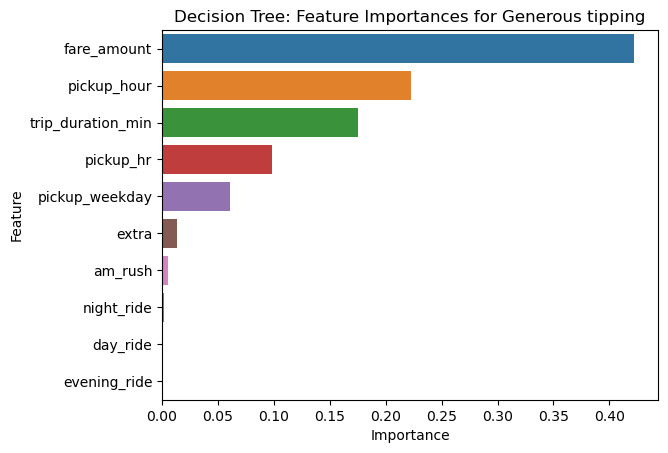

In [1176]:
# Decision Tree future of importance 

dt_cv_importances = pd.DataFrame(dt_cv.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
dt_cv_importances = dt_cv_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
dt_cv_importances = dt_cv_importances[dt_cv_importances['gini_importance'] != 0]
print(dt_cv_importances)
sns.barplot(data=dt_cv_importances, x="gini_importance", y=dt_cv_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Generous tipping", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

                   gini_importance
fare_amount               0.380666
trip_duration_min         0.219023
pickup_hour               0.111062
pickup_hr                 0.104747
pickup_weekday            0.065103
day_ride                  0.058396
night_ride                0.026256
extra                     0.024115
am_rush                   0.004378
evening_ride              0.003550
pm_rush                   0.002703


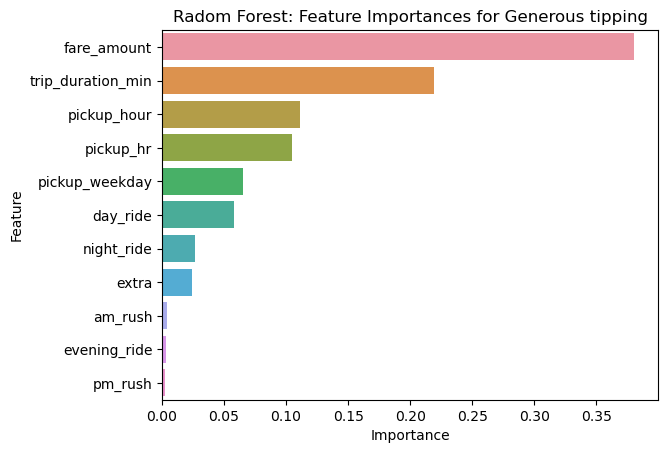

In [1178]:
# Random Forest future of importance 

rf_cv_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
rf_cv_importances = rf_cv_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
rf_cv_importances = rf_cv_importances[rf_cv_importances['gini_importance'] != 0]
print(rf_cv_importances)
sns.barplot(data=rf_cv_importances, x="gini_importance", y=rf_cv_importances.index, orient='h')
plt.title("Radom Forest: Feature Importances for Generous tipping", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

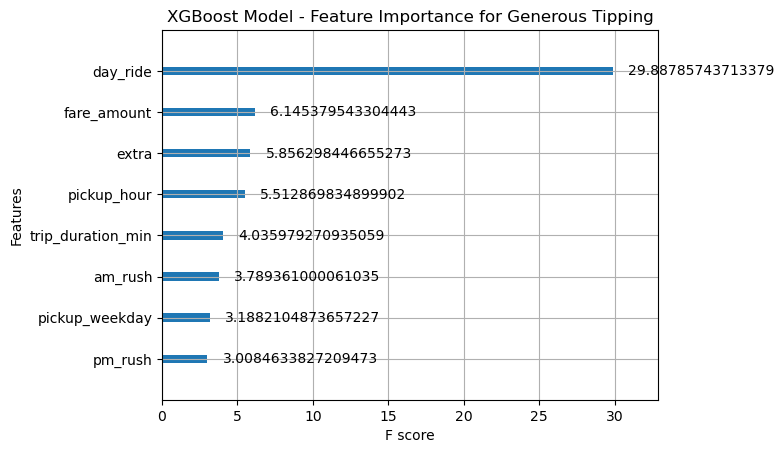

In [1179]:
# Plot feature importance
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Plot feature importance
ax = plot_importance(xgb_model, importance_type='gain')


plt.title('XGBoost Model - Feature Importance for Generous Tipping')
# Show the plot
plt.show()

In [1180]:
# The F score in the feature importance plot is simply a count of how often a feature appears 
# in the decision-making process during tree construction.